***
# <font> ADS Tuner</font>
<p style="margin-left:10%; margin-right:10%;"> <font color=teal> 

***

## Overview:

Hyperparameter optimization requires a model, dataset, and an `ADSTuner` object to perform the search.

`ADSTuner()` Performs a hyperparameter search using [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). You can specify the number of folds you want to use with the `cv` parameter.

The `ADSTuner()` needs a search space to tune the hyperparameters in so you use the `strategy` parameter. This parameter can be set in two ways. You can specify detailed search criteria or you can use the built-in defaults. For the supported model classes, `ADSTuner` provides `perfunctory`and `detailed` search spaces that are optimized for the class of model that is being used. The `perfunctory` option is optimized for a small search space so that the most important hyperparameters are tuned. Generally, this option is used early in your search as it reduces the computational cost and allows you to assess the quality of the model class that you are using. The `detailed` search space instructs `ADSTuner` to cover a broad search space by tuning more hyperparameters. Typically, you would use it when you have determined what class of model is best suited for the dataset and type of problem you are working on. If you have experience with the dataset and have a good idea of what the best hyperparameter values are, you can explicitly specify the search space. You pass a dictionary that defines the search space into the `strategy`.

The parameter `storage` takes a database URL. For example, `sqlite:////home/datascience/example.db`. When `storage` is set to the default value `None`, a new sqlite database file is created internally in the `tmp` folder with a unique name. The name format is `sqlite:////tmp/hpo_*.db`. `study_name` is the name of this study for this `ADSTuner` object. One `ADSTuner` object only has one `study_name`. However, one database file can be shared among different `ADSTuner` objects. `load_if_exists` controls whether to load an existing study from an existing database file. If `False`, it raises a `DuplicatedStudyError` when the `study_name` exists.

The `loglevel` parameter controls the amount of logging information displayed in the notebook.

This notebook uses the scikit-learn `SGDClassifer()` model and the iris dataset. This model object is a regularized linear model with [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD) used to optimize the model parameters.

The next cell creates the `SGDClassifer()` model, initialize san `ADSTuner` object, and loads the `iris data`.

Please select the  pubhished conda envionment data-science-gmlv1_0_v1 before proceeding further. 

In [3]:
import category_encoders as ce
import logging
import numpy as np
import os
import pandas as pd
import sklearn
import time
import ads

from ads.hpo.stopping_criterion import *
from ads.hpo.distributions import *
from ads.hpo.search_cv import ADSTuner, State

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

In [4]:
ads.hello()



  O  o-o   o-o
 / \ |  \ |
o---o|   O o-o
|   ||  /     |
o   oo-o  o--o

ads v2.8.11
oci v2.114.0
ocifs v1.1.3




In [5]:
tuner = ADSTuner(SGDClassifier(), cv=3, loglevel=logging.WARNING)
X, y = load_iris(return_X_y=True)

[I 2023-11-10 05:12:23,994] A new study created in RDB with name: hpo_dae0abaa-63a6-4705-a65c-36f4820ec9bc


Each model class has a set of hyperparameters that you need to optimize. The `strategy` attribute returns what strategy is being used. This can be `perfunctory`, `detailed`, or a dictionary that defines the strategy. The method `search_space()` always returns a dictionary of hyperparameters that are to be searched. Any hyperparameter that is required by the model, but is not listed, uses the default value that is defined by the model class. To see what search space is being used for your model class when `strategy` is `perfunctory` or `detailed` use the `search_space()` method to see the details.

The next cell displaces the search strategy and the search space.

In [6]:
print(f'Search Space for strategy "{tuner.strategy}" is: \n {tuner.search_space()}')

Search Space for strategy "perfunctory" is: 
 {'alpha': LogUniformDistribution(low=0.0001, high=0.1), 'penalty': CategoricalDistribution(choices=['l1', 'l2', None])}


The `tune()` method starts a tuning process. It has a synchronous and asynchronous mode for tuning. The mode is set with the `synchronous` parameter. When it is set to `False`, the tuning process runs asynchronously so it runs in the background and allows you to continue your work in the notebook. When `synchronous` is set to `True`, the notebook is blocked until `tune()` finishes running. The `adntuner_sync_and_async.ipynb` notebook illustrates this feature in a more detailed way.

The `ADSTuner` object needs to know when to stop tuning. The `exit_criterion` parameter accepts a list of criteria that cause the tuning to finish. If any of the criteria are met, then the tuning process stops. Valid exit criteria are:

* `NTrials(n)`: Run for `n` number of trials.
* `TimeBudget(t)`: Run for `t` seconds.
* `ScoreValue(s)`: Run until the score value exceeds `s`.

The default behavior is to run for 50 trials (`NTrials(50)`).

The stopping criteria are listed in the [`ads.hpo.stopping_criterion`](https://docs.oracle.com/en-us/iaas/tools/ads-sdk/latest/ads.hpo.html#module-ads.hpo.stopping_criterion) module.

<a id='ntrials'></a>
## Synchronous Tuning with Exit Criterion Based on Number of Trials

This section demonstrates how to perform a synchronous tuning process with the exit criteria based on the number of trials. In the next cell, the `synchronous` parameter is set to `True` and the `exit_criterion` is set to `[NTrials(5)]`. 

In [7]:
tuner.tune(X, y, exit_criterion=[NTrials(5)], synchronous=True)

You can access a summary of the trials by looking at the various attributes of the `tuner` object. The `scoring_name` attribute is a string that defines the name of the scoring metric. The `best_score` attribute gives the best score of all the completed trials. The `best_params` parameter defines the values of the hyperparameters that have to lead to the best score. Hyperparameters that are not in the search criteria are not reported.

In [8]:
print(f"So far the best {tuner.scoring_name} score is {tuner.best_score} and the best hyperparameters are {tuner.best_params}")

So far the best mean accuracy score is 0.96 and the best hyperparameters are {'alpha': 0.0003637405089080681, 'penalty': 'l1'}


You can also look at the detailed table of all the trials attempted: 

In [9]:
tuner.trials.tail()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_penalty,user_attrs_mean_fit_time,user_attrs_mean_score_time,user_attrs_mean_test_score,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
0,0,0.900000,2023-11-10 05:12:35.493741,2023-11-10 05:12:37.157940,0 days 00:00:01.664199,0.068434,l2,0.118520,0.025983,0.900000,mean accuracy,0.86,0.94,0.90,0.004280,0.001033,0.032660,COMPLETE
1,1,0.846667,2023-11-10 05:12:37.169888,2023-11-10 05:12:38.645204,0 days 00:00:01.475316,0.000482,l2,0.113007,0.025222,0.846667,mean accuracy,0.78,0.88,0.88,0.004102,0.000855,0.047140,COMPLETE
2,2,0.846667,2023-11-10 05:12:38.654189,2023-11-10 05:12:40.111173,0 days 00:00:01.456984,0.070133,l1,0.112901,0.024552,0.846667,mean accuracy,0.86,0.92,0.76,0.003466,0.000828,0.065997,COMPLETE
3,3,0.920000,2023-11-10 05:12:40.120391,2023-11-10 05:12:41.548136,0 days 00:00:01.427745,0.000766,l2,0.110290,0.024094,0.920000,mean accuracy,0.98,0.86,0.92,0.002748,0.000414,0.048990,COMPLETE
4,4,0.960000,2023-11-10 05:12:41.556948,2023-11-10 05:12:42.984315,0 days 00:00:01.427367,0.000364,l1,0.111004,0.024132,0.960000,mean accuracy,1.00,0.94,0.94,0.002988,0.000458,0.028284,COMPLETE


<a id='resume'></a>
## Asynchronously Tuning with Exit Criterion Based on Time Budget

`ADSTuner()` tuner can be run in an asynchronous mode by setting `synchronous=False` in the `tune()` method. This allows you to run other Python commands while the tuning process is executing in the background. This section demonstrates how to run an asynchronous search for the optimal hyperparameters. It uses a stopping criteria of five seconds. This is controlled by the parameter `exit_criterion=[TimeBudget(5)]`.

The next cell starts an asynchronous tuning process. A loop is created that prints the best search results that have been detected so far by using the `best_score` attribute. It also displays the remaining time in the time budget by using the `time_remaining` attribute. The attribute `status` is used to exit the loop.

In [10]:
# This cell will return right away since it's running asynchronous.
tuner.tune(exit_criterion=[TimeBudget(5)])
while tuner.status == State.RUNNING:
    print(f"So far the best score is {tuner.best_score} and the time left is {tuner.time_remaining}")
    time.sleep(1)

So far the best score is 0.96 and the time left is 4.9770801067352295
So far the best score is 0.96 and the time left is 3.9623072147369385
So far the best score is 0.96 and the time left is 2.9443955421447754
So far the best score is 0.96 and the time left is 1.9325056076049805
So far the best score is 0.9733333333333333 and the time left is 0.9133002758026123
So far the best score is 0.9733333333333333 and the time left is 0


The attribute `best_index` givse you the index in the `trials` data frame where the best model is located.

In [11]:
tuner.trials.loc[tuner.best_index, :]

number                                                  10
value                                             0.973333
datetime_start                  2023-11-10 05:12:56.889113
datetime_complete               2023-11-10 05:12:58.351541
duration                            0 days 00:00:01.462428
params_alpha                                      0.004763
params_penalty                                        None
user_attrs_mean_fit_time                          0.108755
user_attrs_mean_score_time                        0.023586
user_attrs_mean_test_score                        0.973333
user_attrs_metric                            mean accuracy
user_attrs_split0_test_score                           1.0
user_attrs_split1_test_score                          0.96
user_attrs_split2_test_score                          0.96
user_attrs_std_fit_time                            0.00359
user_attrs_std_score_time                         0.000631
user_attrs_std_test_score                         0.0188

The attribute `n_trials` reports the number of successfully complete trials that were conducted.

In [12]:
print(f"The total of trials was: {tuner.n_trials}.")

The total of trials was: 13.


<a id='inspect'></a>
## Inspecting the Tuning Trials

You can inspect the tuning trials performance using several built in plots.

**Note**: If the tuning process is still running in the background, the plot runs in real time to update the new changes until the tuning process completes.

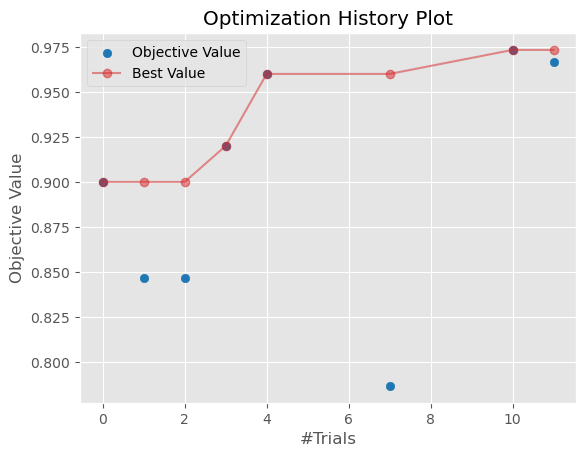

In [13]:
# tuner.tune(exit_criterion=[NTrials(5)], loglevel=logging.WARNING) # uncomment this line to see the real-time plot.
tuner.plot_best_scores()

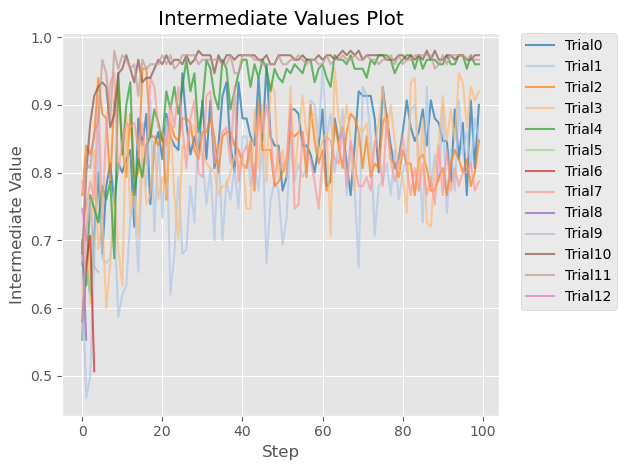

In [14]:
tuner.plot_intermediate_scores()

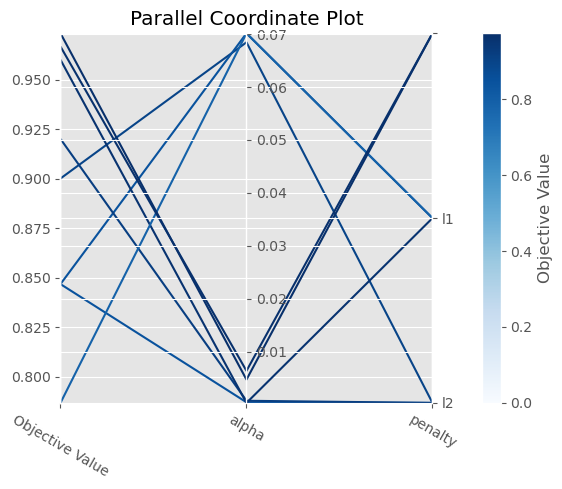

In [15]:
tuner.plot_parallel_coordinate_scores(params=['penalty', 'alpha'])

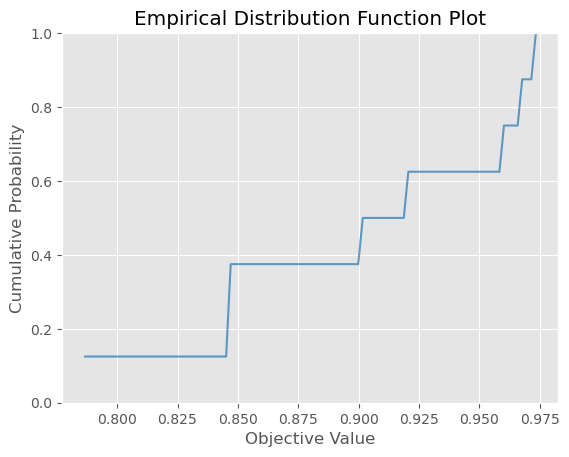

In [16]:
tuner.plot_edf_scores()

Waiting for more trials before evaluating the param importance.


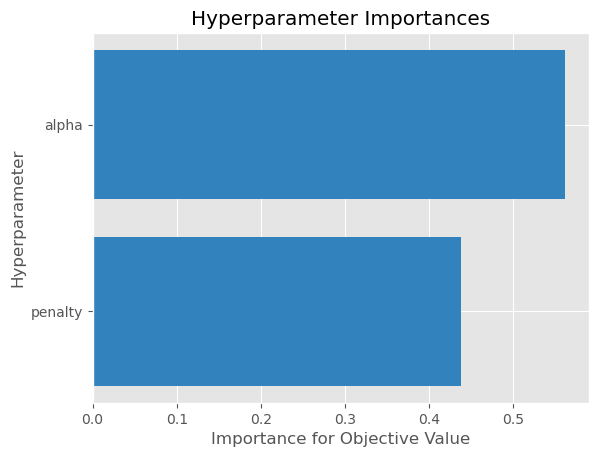

In [17]:
tuner.plot_param_importance()

<a id='custom'></a>
# Defining a Custom Search Space and Score

Instead of using a `perfunctory` or `detailed` strategy, define a custom search space strategy. 

The next cell, creates a `LogisticRegression()` model instance then defines a custom search space strategy for the three `LogisticRegression()` hyperparameters, `C`, `solver`, and `max_iter` parameters. 

You can define a custom `scoring` parameter, see <a id='pipeline'>Optimizing a scikit-learn `Pipeline()`</a> though this example uses the standard weighted average $F_1$, `f1_score`.

In [18]:
tuner = ADSTuner(LogisticRegression(), 
                 strategy = {'C': LogUniformDistribution(low=1e-05, high=1),
                             'solver': CategoricalDistribution(['saga']),
                             'max_iter': IntUniformDistribution(500, 2000, 50)},
                 scoring=make_scorer(f1_score, average='weighted'),
                 cv=3)
tuner.tune(X, y, exit_criterion=[NTrials(5)], synchronous=True, loglevel=logging.WARNING)

<a id='search-space'></a>
## Changing the Search Space Strategy

You can change the search space in the following three ways:

- add new hyperparameters
- remove existing hyperparameters
- modify the range of existing non-categorical hyperparameters

**Note**: You can't change the distribution of an existing hyperparameter or make any changes to a hyperparameter that is based on a categorical distribution. You need to initiate a new `ADSTuner` object for those cases. For more detailed information, review the `adstuner_search_space_update.ipynb` notebook.

The next cell switches to a `detailed` strategy. All previous values set for `C`, `solver`, and `max_iter` are kept, and `ADSTuner` infers distributions for the remaining hyperparameters. You can force an overwrite by setting `overwrite=True`. 

In [19]:
tuner.search_space(strategy='detailed')

{'C': LogUniformDistribution(low=1e-05, high=10),
 'solver': CategoricalDistribution(choices=['saga']),
 'max_iter': IntUniformDistribution(low=500, high=2000, step=50),
 'dual': CategoricalDistribution(choices=[False]),
 'penalty': CategoricalDistribution(choices=['elasticnet']),
 'l1_ratio': UniformDistribution(low=0, high=1)}

Alternatively, you can edit a subset of the search space by changing the range.

In [21]:
tuner.search_space(strategy={'C': LogUniformDistribution(low=1e-05, high=1)})

{'C': LogUniformDistribution(low=1e-05, high=1),
 'dual': CategoricalDistribution(choices=[False]),
 'penalty': CategoricalDistribution(choices=['elasticnet']),
 'solver': CategoricalDistribution(choices=['saga']),
 'l1_ratio': UniformDistribution(low=0, high=1)}

Here's an example of using `overwrite=True` to reset to the default values for `detailed`: 

In [20]:
tuner.search_space(strategy='detailed', overwrite=True)

{'C': LogUniformDistribution(low=1e-05, high=10),
 'dual': CategoricalDistribution(choices=[False]),
 'penalty': CategoricalDistribution(choices=['elasticnet']),
 'solver': CategoricalDistribution(choices=['saga']),
 'l1_ratio': UniformDistribution(low=0, high=1)}

In [22]:
tuner.tune(X, y, exit_criterion=[NTrials(5)], synchronous=True, loglevel=logging.WARNING)

<a id='pipeline'></a>
# Optimizing a scikit-learn `Pipeline()` 

The following example demonstrates how the `ADSTuner` hyperparameter optimization engine can optimize the **sklearn** `Pipeline()` objects. 

You create a scikit-learn `Pipeline()` model object and use `ADSTuner` to optimize its performance on the iris dataset from sklearn.

The dataset is then split into X and y, which refers to the training features and the target feature respectively. Again, applying a `train_test_split()` call splits the data into training and validation datasets.

In [23]:
X, y = load_iris(return_X_y=True)
X = pd.DataFrame(data=X, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
y = pd.DataFrame(data=y)

numeric_features = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
categorical_features = y.select_dtypes(include=['object', 'category', 'bool']).columns

y = preprocessing.LabelEncoder().fit_transform(y)

num_features = len(numeric_features) + len(categorical_features)

numeric_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('num_scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('cat_encoder', ce.woe.WOEEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(f_classif, k=int(0.9 * num_features))),
        ('classifier', LogisticRegression())
    ]
)

You can define a custom score function. In this example, it is directly measuring how close the predicted y-values are to the true y-values by taking the weighted average of the number of direct matches between the y-values.

In [24]:
def custom_score(y_true, y_pred, sample_weight=None):
    score = (y_true == y_pred)
    return np.average(score, weights=sample_weight)

score = make_scorer(custom_score)

Again, you instantiate the `ADSTuner()` object and use it to tune the iri` dataset:

In [25]:
ads_search = ADSTuner(
    pipe,
    scoring=score,
    strategy='detailed',
    cv=2,
    random_state=42)

ads_search.tune(X=X, y=y, exit_criterion=[NTrials(20)], synchronous=True, loglevel=logging.WARNING)

The `ads_search` tuner can provide useful information about the tuning process, like the best parameter that was optimized, the best score achieved, the number of trials, and so on.

In [26]:
ads_search.sklearn_steps

{'classifier__C': 9.696426825473054,
 'classifier__dual': False,
 'classifier__l1_ratio': 0.578617860380836,
 'classifier__penalty': 'elasticnet',
 'classifier__solver': 'saga'}

In [27]:
ads_search.best_params

{'C': 9.696426825473054,
 'dual': False,
 'l1_ratio': 0.578617860380836,
 'penalty': 'elasticnet',
 'solver': 'saga'}

In [28]:
ads_search.best_score

0.9666666666666667

In [29]:
ads_search.best_index

5

In [30]:
ads_search.trials.head()

,number,value,datetime_start,datetime_complete,duration,params_classifier__C,params_classifier__dual,params_classifier__l1_ratio,params_classifier__penalty,params_classifier__solver,user_attrs_mean_fit_time,user_attrs_mean_score_time,user_attrs_mean_test_score,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
0,0,0.846667,2023-11-10 05:14:23.199725,2023-11-10 05:14:23.322420,0 days 00:00:00.122695,0.045698,False,0.531274,elasticnet,saga,0.007273,0.002261,0.846667,mean accuracy,0.813333,0.880000,0.001525,0.000210,0.033333,COMPLETE
1,1,0.333333,2023-11-10 05:14:23.333715,2023-11-10 05:14:23.442154,0 days 00:00:00.108439,0.000136,False,0.820629,elasticnet,saga,0.005823,0.002092,0.333333,mean accuracy,0.333333,0.333333,0.000430,0.000069,0.000000,COMPLETE
2,2,0.926667,2023-11-10 05:14:23.451261,2023-11-10 05:14:23.560142,0 days 00:00:00.108881,0.123905,False,0.833164,elasticnet,saga,0.006438,0.002057,0.926667,mean accuracy,0.906667,0.946667,0.000401,0.000033,0.020000,COMPLETE
3,3,0.333333,2023-11-10 05:14:23.569392,2023-11-10 05:14:23.677244,0 days 00:00:00.107852,0.002854,False,0.848953,elasticnet,saga,0.005732,0.002123,0.333333,mean accuracy,0.333333,0.333333,0.000389,0.000044,0.000000,COMPLETE
4,4,0.333333,2023-11-10 05:14:23.686799,2023-11-10 05:14:23.794896,0 days 00:00:00.108097,0.000477,False,0.173963,elasticnet,saga,0.005917,0.002150,0.333333,mean accuracy,0.333333,0.333333,0.000352,0.000078,0.000000,COMPLETE


In [31]:
ads_search.n_trials

20